# Loading dataset

In [ ]:
# First, let's install pydrive module to acces google drive directory
! pip install pydrive

In [ ]:
# Let's create an access to google drive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# Test Set .tar
# Use the file ID to transfer the file from GoogleDrive to Colab
download = drive.CreateFile({'id': '1uekiAYzq3r-YmIFOMsf887JyloGmUvB0'})
# Download the file and save with the specific name 'test.tar'
download.GetContentFile('test.tar')


# Train Set .tar
# Use the file ID to transfer the file from GoogleDrive to Colab
download = drive.CreateFile({'id': '1zwhiNz6H1-dm7HAsUopol2vC-e6mFC4c'})
# Download the file and save with the specific name 'train.tar'
download.GetContentFile('train.tar')


# Valid Set .tar
# Use the file ID to transfer the file from GoogleDrive to Colab
download = drive.CreateFile({'id': '1qkFCkVxgKcrZcbLDzJULLbivm80KWfu-'})
# Download the file and save with the specific name 'valid.tar'
download.GetContentFile('valid.tar')


# Upload and Extract .tar files in content/cell_images folder

In [ ]:
# Upload test.tar from Google Drive to colab
upload = drive.CreateFile({'title': 'test.tar'})
upload.SetContentFile('test.tar')
upload.Upload()

# Let's create a directory to extract our dataset
! mkdir -p content/cell_images

#Extract content test.tar
!tar -xvf  test.tar -C content/cell_images


# Upload train.tar from Google Drive to colab
upload = drive.CreateFile({'title': 'train.tar'})
upload.SetContentFile('train.tar')
upload.Upload()

#Extract content test.tar
!tar -xvf  train.tar -C content/cell_images


# Upload valid.tar from Google Drive to colab
upload = drive.CreateFile({'title': 'valid.tar'})
upload.SetContentFile('valid.tar')
upload.Upload()

#Extract content test.tar
!tar -xvf  valid.tar -C content/cell_images

In [ ]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    malaria_files = np.array(data['filenames'])
    malaria_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return malaria_files, malaria_targets

train_path = 'content/cell_images/r_train'
valid_path = 'content/cell_images/r_valid'
test_path = 'content/cell_images/r_test'

train_files, train_targets = load_dataset(train_path)
valid_files, valid_targets = load_dataset(valid_path)
test_files, test_targets = load_dataset(test_path)

print(f'Full data shape: {len(train_files) + len(valid_files) +len(test_files)} |' 
      f'Full data target shape: {len(train_targets) + len(valid_targets) + len(test_targets)}')
print(f'Train shape: {len(train_files)} | Train Target shape: {len(train_targets)}')
print(f'Valid shape: {len(valid_files)} | Valid Target shape: {len(valid_targets)}')
print(f'Test shape: {len(test_files)}  | Test Target shape: {len(test_targets)}') 



Full data shape: 27558 |Full data target shape: 27558
Train shape: 19290 | Train Target shape: 19290
Valid shape: 2756 | Valid Target shape: 2756
Test shape: 5512  | Test Target shape: 5512


# Pre-process the data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#Define a ImageDataGenerator for each dataset. 
#This augmentation process is only to rescale each imagem to 1/255

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)
datagen_valid = ImageDataGenerator(rescale=1./255)

#Let's Create a ImageDataGenerator Just for visualize (without rescale)
just_for_visualize = ImageDataGenerator()
just_for_visualize_generator = just_for_visualize.flow_from_directory(
    'content/cell_images/r_test', #Train folder path 
    target_size=(150,150),
    batch_size=5512,
    shuffle=False)



#Define a batch_size parameter
batch_size=32

# Here .flow_from_directory is used to transform 
train_generator = datagen_train.flow_from_directory(
    'content/cell_images/r_train', #Train folder path 
    target_size=(150,150), #all images will be resized to 224x224
    batch_size=batch_size,
    class_mode='categorical') # We use categorical_crossentropy loss, 
                              # we need categorical labels


test_generator = datagen_test.flow_from_directory(
    'content/cell_images/r_test', #Test folder path
    target_size=(150,150), #all images will be resized to 224x224
    batch_size=52,
    class_mode='categorical',
    shuffle=False) 

valid_generator = datagen_valid.flow_from_directory(
    'content/cell_images/r_valid', #all images will be resized to 224x224
    target_size=(150,150),
    batch_size=26,
    class_mode='categorical') 
    




Found 5512 images belonging to 2 classes.
Found 19290 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


# Visualizing some images

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


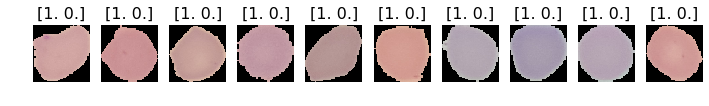

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras.preprocessing.image import ImageDataGenerator

# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(just_for_visualize_generator)
plots(imgs[:10], titles=labels)


# Create a CNN (model 2)
---



In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import regularizers

model = Sequential()
model.add(Conv2D(16, kernel_size=2, padding='same', 
                 activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))


# Compile the model 
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 16)      208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 128)       16512     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 41472)             0         
__________

## Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define epochs number
epochs = 20

# Create a checkpointer to save only the best params
checkpointer = ModelCheckpoint(filepath='cnn_model_2_new.weights.best.hdf5', 
                              verbose=1, save_best_only=True)

history_m2 = model.fit_generator(train_generator,
                   steps_per_epoch=train_generator.samples//batch_size,
                   epochs=epochs,
                   callbacks=[checkpointer],
                   validation_data=valid_generator,
                   validation_steps=106)



In [ ]:
plt.plot(history_m2.history['acc'], color='red', label='Train set')
plt.plot(history_m2.history['val_acc'], color='green', label='Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy score')
plt.legend()

In [ ]:
from matplotlib.patches import Ellipse
from matplotlib.ticker import MaxNLocator
#...

fig, ax = plt.subplots(figsize=(10,6))


ax.plot(history_m2.history['loss'], color='m', label='Training losses', linestyle='--')
ax.plot(history_m2.history['val_loss'], color='c', label='Validation losses')
ax.xaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=18))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

circle_1 = Ellipse((8, 0.17), width=1, height=.02 ,fill=False,
                  linestyle='--', linewidth=3)
plt.gcf().gca().add_patch(circle_1)

plt.savefig('model_2_loses.png', bbox_inches='tight')

## Load the model with the best validation accuracy

In [ ]:
# load the weights that yielded the best validation accuracy
model.load_weights('cnn_model_2.weights.best.hdf5')


##Evaluate the model

In [ ]:
valid_generator = datagen_valid.flow_from_directory(
    'content/cell_images/r_valid', #all images will be resized to 150x150
    target_size=(150,150),
    batch_size=26,
    class_mode='categorical',
    shuffle=False)


#evaluate and print test accuracy
score = model.evaluate_generator(valid_generator, steps=106)
print('\n', 'Valid accuracy:', score[1])

#evaluate and print test accuracy
score = model.evaluate_generator(test_generator, steps=106)
print('\n', 'Test accuracy:', score[1])


Found 2756 images belonging to 2 classes.

 Valid accuracy: 0.947024663101952

 Test accuracy: 0.9513788048951131


### Predict values on test set and create a confusion matrix

In [ ]:
# Let's use a function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[2681   75]
 [ 193 2563]]


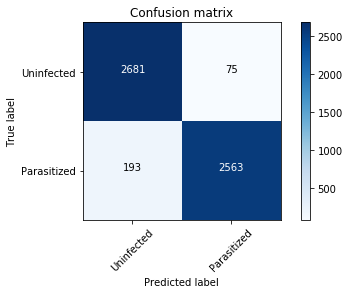

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_generator.reset()

predictions = model.predict_generator(test_generator, steps=106)
y_predictions = np.argmax(predictions, axis=1)

confusion_matrix = confusion_matrix(test_generator.classes, y_predictions)
classe_names = ['Uninfected', 'Parasitized']
plot_confusion_matrix(confusion_matrix, classe_names)
plt.savefig('model_2_confusion_matrix.png', bbox_inches='tight')

In [ ]:
print(classification_report(test_generator.classes, y_predictions, target_names=classe_names))

print(f'Accuracy score: {accuracy_score(test_generator.classes, y_predictions)}')

              precision    recall  f1-score   support

  Uninfected       0.93      0.97      0.95      2756
 Parasitized       0.97      0.93      0.95      2756

   micro avg       0.95      0.95      0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512

Accuracy score: 0.951378809869376


###ROC curve

In [ ]:
predictions_only_true = predictions[:,1]
predictions_only_true

array([0.02679917, 0.01624809, 0.02216694, ..., 0.5490485 , 0.9068196 ,
       0.9999908 ], dtype=float32)

AUC: 0.9759683187598611


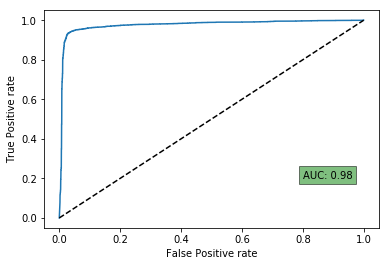

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, threshold = roc_curve(test_generator.classes, predictions_only_true)
area_uc = roc_auc_score(test_generator.classes, predictions_only_true)
print(f'AUC: {area_uc}')
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.text(0.8, 0.2, s=f'AUC: {area_uc:.2f}', 
         bbox=dict(facecolor='green', alpha=0.5))

plt.savefig('model_2_roc.png', bbox_inches='tight')

Found 5512 images belonging to 2 classes.


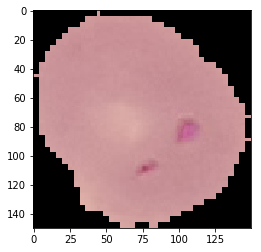

In [ ]:
import cv2

test_generator_plot = datagen_test.flow_from_directory(
    'content/cell_images/r_test', #Test folder path
    target_size=(150,150), #all images will be resized to 224x224
    batch_size=5512,
    class_mode='categorical',
    shuffle=False) 

imgs, labels = test_generator_plot.next()

plt.imshow(imgs[62])

In [ ]:
imgs.shape

(5512, 150, 150, 3)

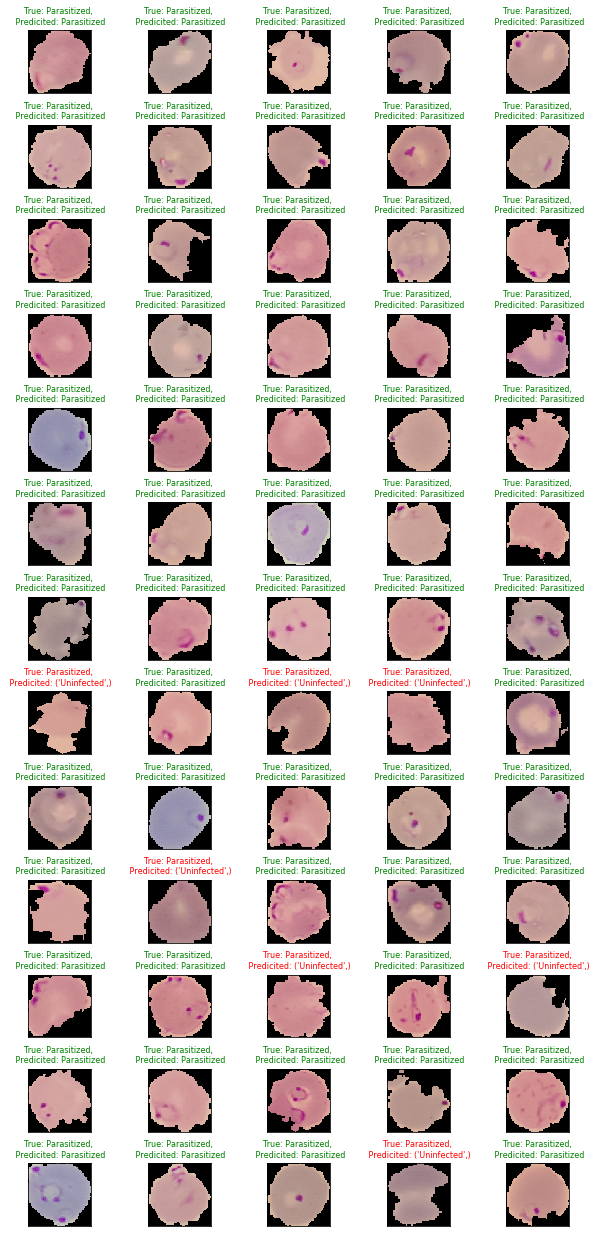

In [ ]:
imgs_selected = imgs[2950:3015]
y_predictions_selected = y_predictions[2950:3015]
y_classes_selected = test_generator.classes[2950:3015]

fig, axs = plt.subplots(nrows=13, ncols=5, figsize=(10,22));
plt.subplots_adjust(hspace = 0.5, wspace=0.5)
for idx, figure in enumerate(imgs_selected):
    ax = axs[int(idx/5), idx%5]
    ax.imshow(imgs_selected[idx])
    if y_predictions_selected[idx] == 0:
        predicted_label = 'Uninfected',
    if y_predictions_selected[idx] == 1:
        predicted_label = 'Parasitized'
    
    if y_classes_selected[idx] == 0:
        true_label = 'Uninfected'
    else:
        true_label = 'Parasitized'
    label = f'True: {true_label}, \n Predicited: {predicted_label}'
    ax.set_title(label, 
                 color=('green' if y_predictions_selected[idx]==y_classes_selected[idx] else 'red'),
                fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig('predictions_imagens_pt2.svg', bbox_inches='tight')

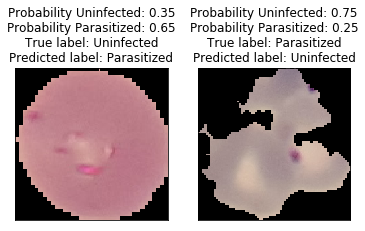

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2)
sample_1 = 581
ax1.imshow(imgs[sample_1])    
ax1.set_xticks([])
ax1.set_yticks([])
label = (f'Probability Uninfected: {predictions[sample_1][0]:.2f}'
        f'\nProbability Parasitized: {predictions[sample_1][1]:.2f}'
        f"\nTrue label: {'Uninfected' if test_generator.classes[sample_1] == 0 else 'Parasitized'}"
        f"\nPredicted label: {'Uninfected' if y_predictions[sample_1] == 0 else 'Parasitized'}")

ax1.set_title(label)

sample_2 = 3151
ax2.imshow(imgs[sample_2])    
ax2.set_xticks([])
ax2.set_yticks([])
label2 = (f'Probability Uninfected: {predictions[sample_2][0]:.2f}'
        f'\nProbability Parasitized: {predictions[sample_2][1]:.2f}'
        f"\nTrue label: {'Uninfected' if test_generator.classes[sample_2] == 0 else 'Parasitized'}"
        f"\nPredicted label: {'Uninfected' if y_predictions[sample_2] == 0 else 'Parasitized'}")

ax2.set_title(label2)

plt.savefig('predictions_probs_values.svg', bbox_inches='tight')